<a href="https://colab.research.google.com/github/sevwal/BME362_image_analysis/blob/main/BME362_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Analysis**
As a refresher, where did we leave off from image analysis? We got a merged image of all four channels (DAPI, Transfection-GFP, CD48, Succinimidyl Ester). From the images with DAPI and Succs we segmented both nuclei and cells. These segmentations gave us unique cell labels for each cell. We then used these segmentations to extract measurments from the pixel values (signal intensity) from the merged images and assigned them to our labels.

This left us with a large dataframe with many different variables. The dataframe contains the label number, cell area (in pixels), intensity measurements for each channel, along with some morphological features.

What do we want to quantify? We want to check which cells were transfected (GFP control) and then extract their expression of endogenous CD48 for both CD48 WT (well D05) and CD48 mut (well E05).

First up, we'll get right back into it by downloading all the data we created from the image analysis notebook.

In [ ]:
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

In [ ]:
#create new folder for our data
if (not os.path.exists("/content/BME362_data")):
    os.mkdir("/content/BME362_data")

#download files as .zip
!wget https://www.dropbox.com/sh/3wy88wihchyvaq9/AACXMjDTgA5NIe15CvShVc9ta?dl=0 --content-disposition -P "/content/BME362_data"

#unzip .zip
!unzip "/content/BME362_data/BME362_data.zip" -d "/content/BME362_data"

#delete .zip
!rm "/content/BME362_data/BME362_data.zip"

#paths
input_dir = "/content/BME362_data/" 
save_dir = input_dir+"Masks/"
merge_dir = input_dir+"Merged/"
out_dir = input_dir+"Output/"

To answer our experiment question, we first think back to our experiment. **Remember**: What was the original goal of this experiment? What parameters do we need to answer this question? Where can you find these parameters?

From your programming and data analysis courses you should remember that weshould first do some quality checks on our data. For this, we'll do some histograms to check the distribution of variables such as area, or signal intensities. What we are looking for is nicely distributed data. Outliers, or bimodal distribution may give us a hint what we need to filter or what went wrong.

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

dd = pd.read_csv(os.path.join(out_dir, "combined_measurements.csv"))

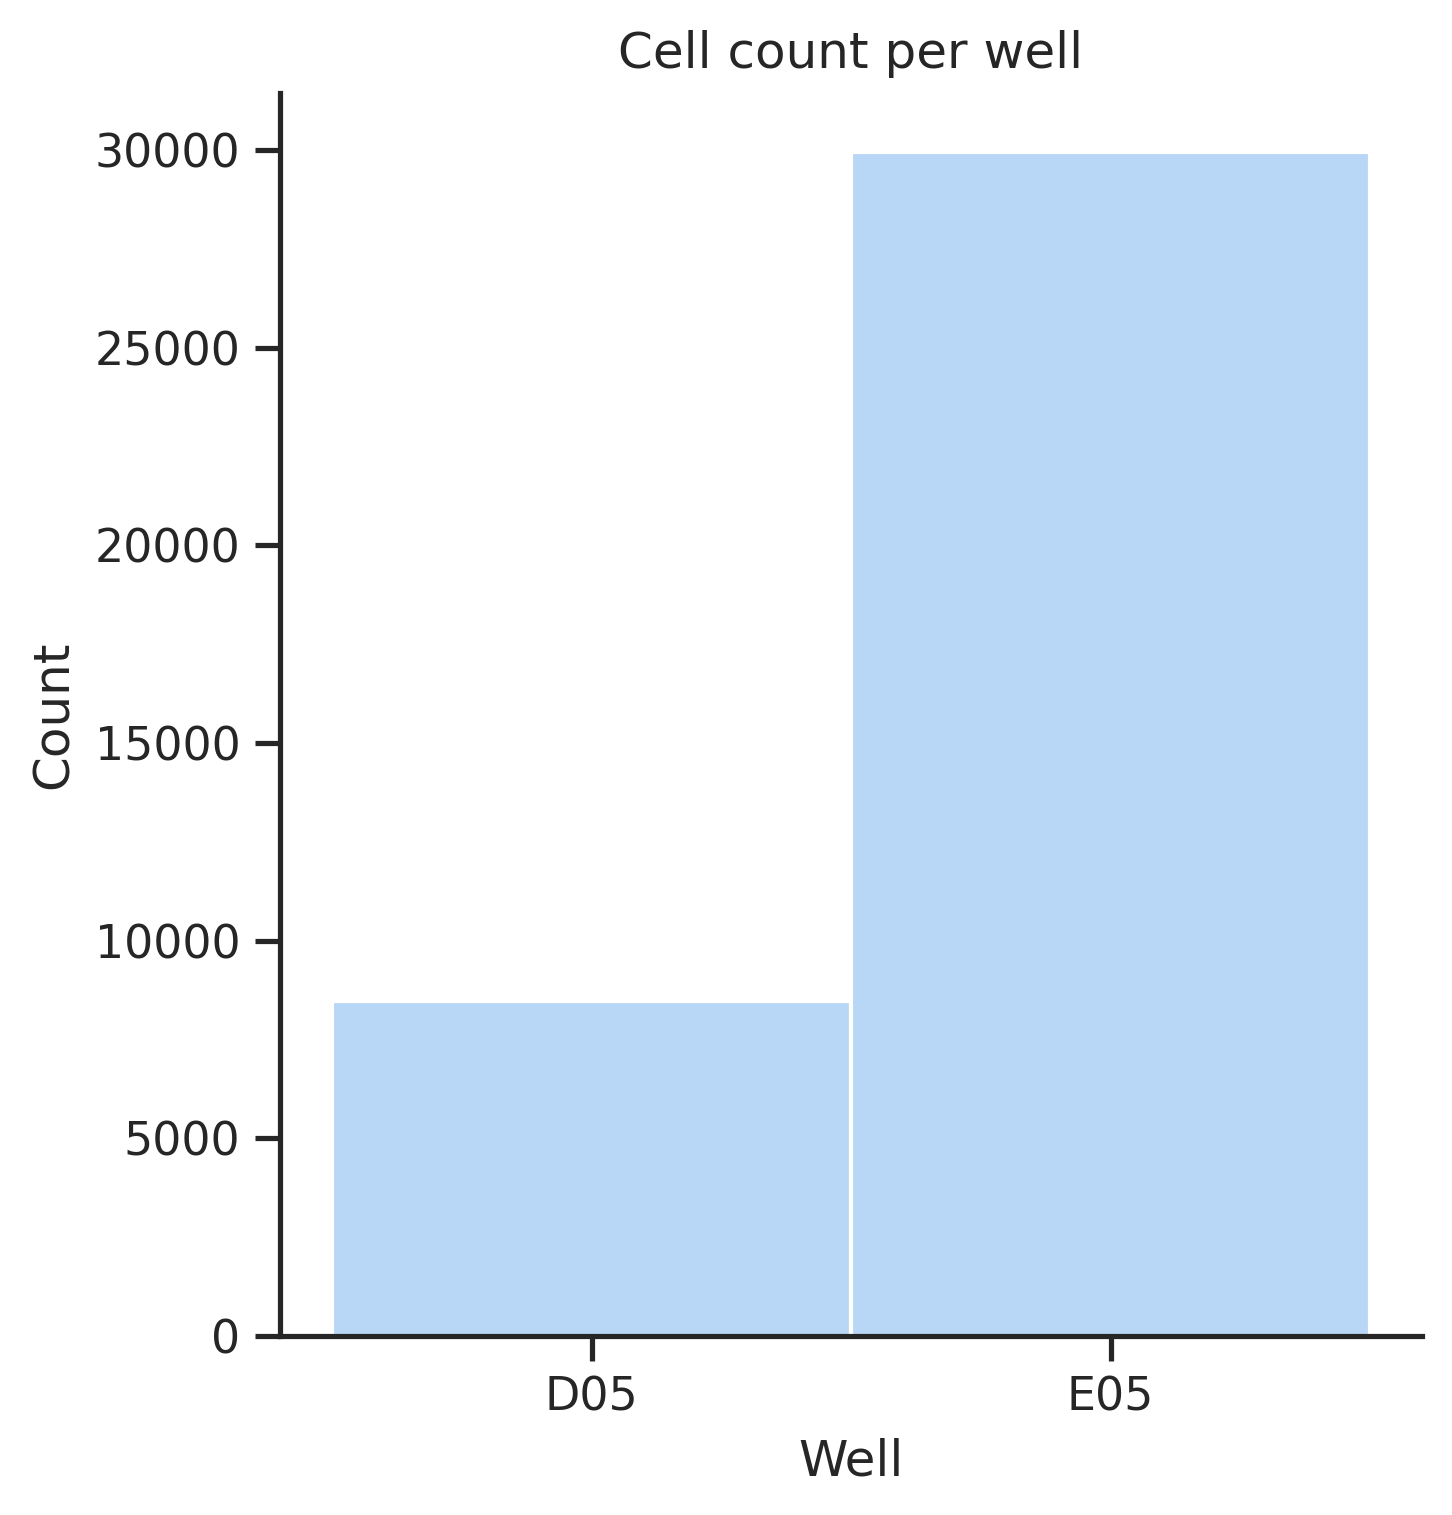

In [ ]:
# To check for differences between our conditions
# Compare the number of cells between wells
p1 = sns.displot(data=dd, x="well",
                facet_kws=dict(margin_titles=True))
p1.set(title="Cell count per well",
      xlabel="Well")

Clearly, there's many more cells that were segmented in well E05. Seems peculiar, so we should keep that in mind.

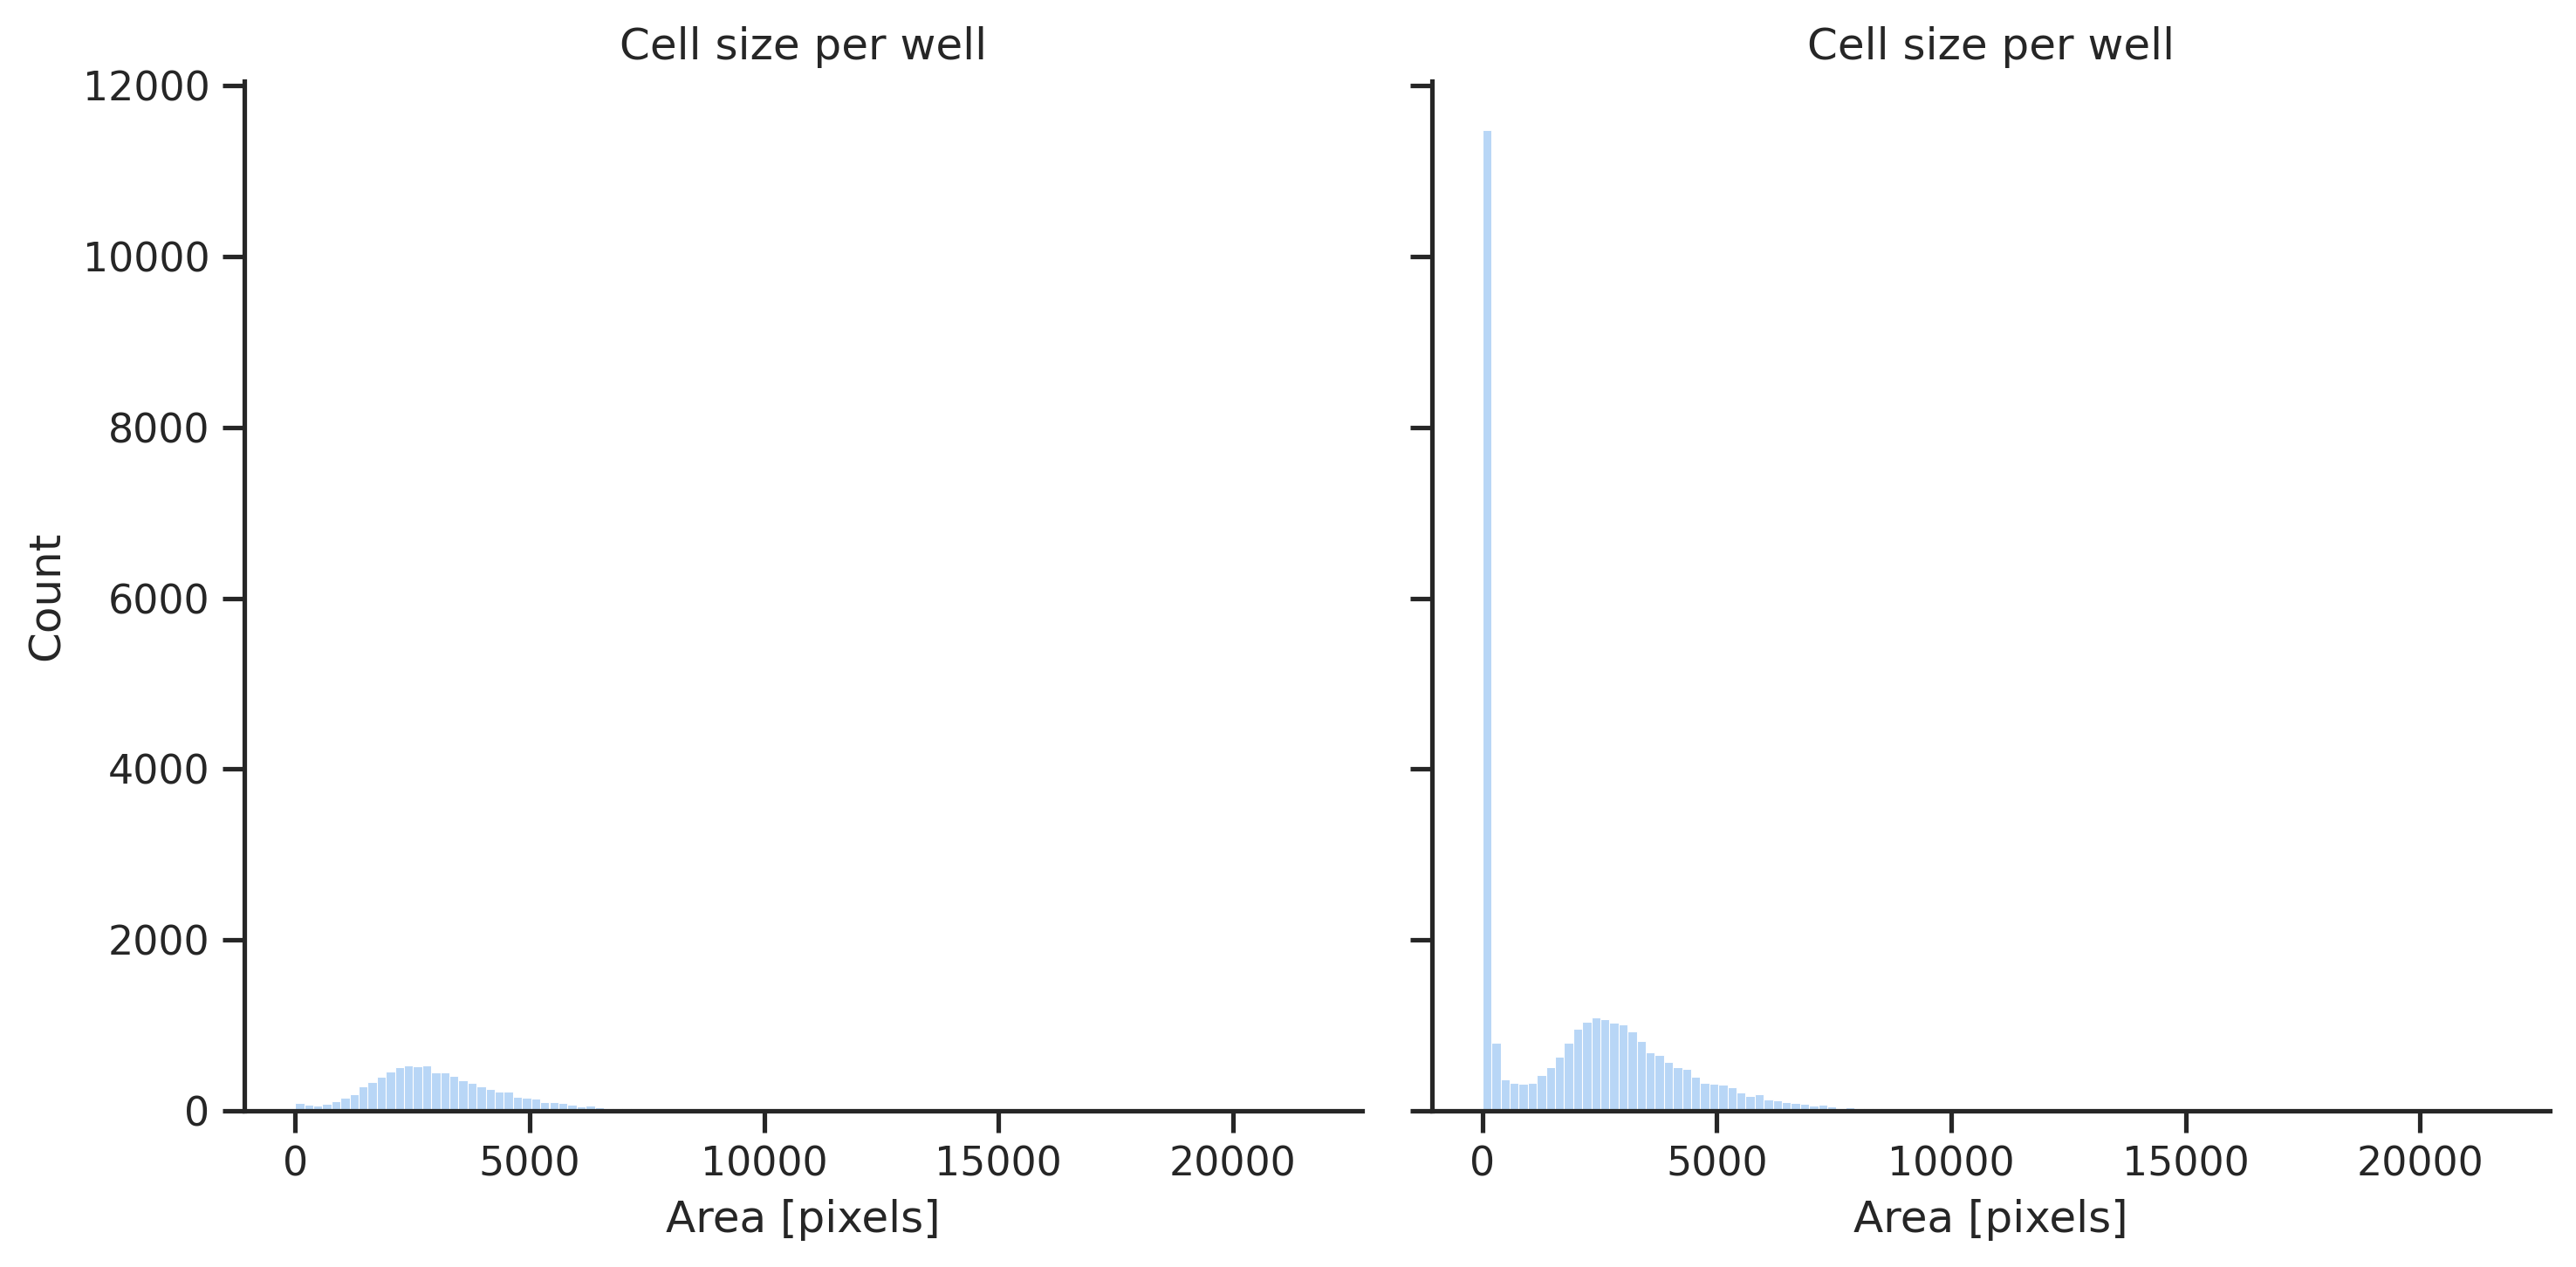

In [ ]:
# To check for differences in segmentation between wells
# Compare the size of cells between wells
p2 = sns.displot(data=dd, x="area", col="well",
                facet_kws=dict(margin_titles=True))

p2.set(title="Cell size per well",
      xlabel="Area [pixels]")

We can see that this large difference in the number of cells between wells D05 and E05 stems from a large number of very small cells being present in well E05. We see that their size is close to 0, and barely any cells of that size are present in well D05. This hints that these cells were missegmented. 

We don't know why, but it might be that cells were more confluent, there was a lot of debris, or our image quality was just bad. If you take a look at some images from well E05 you might notice that the signal intensity is pretty bad for some sites. This indicates to me that something went wrong during image acquisition, like the autofocus messing up.

Moreover, some cells might also be mitotic. For mitotic cells, we would expect them to have a high mean DAPI intensity, as they are dividing and have high DNA content. They are also a lot smaller and elongated (or: more elliptical than regular cells/nuclei).

Now for debris, we would expect that signal to be small and spotty, i.e. more perfectly round than a cell should be.

We can test our assumption with one more plot:

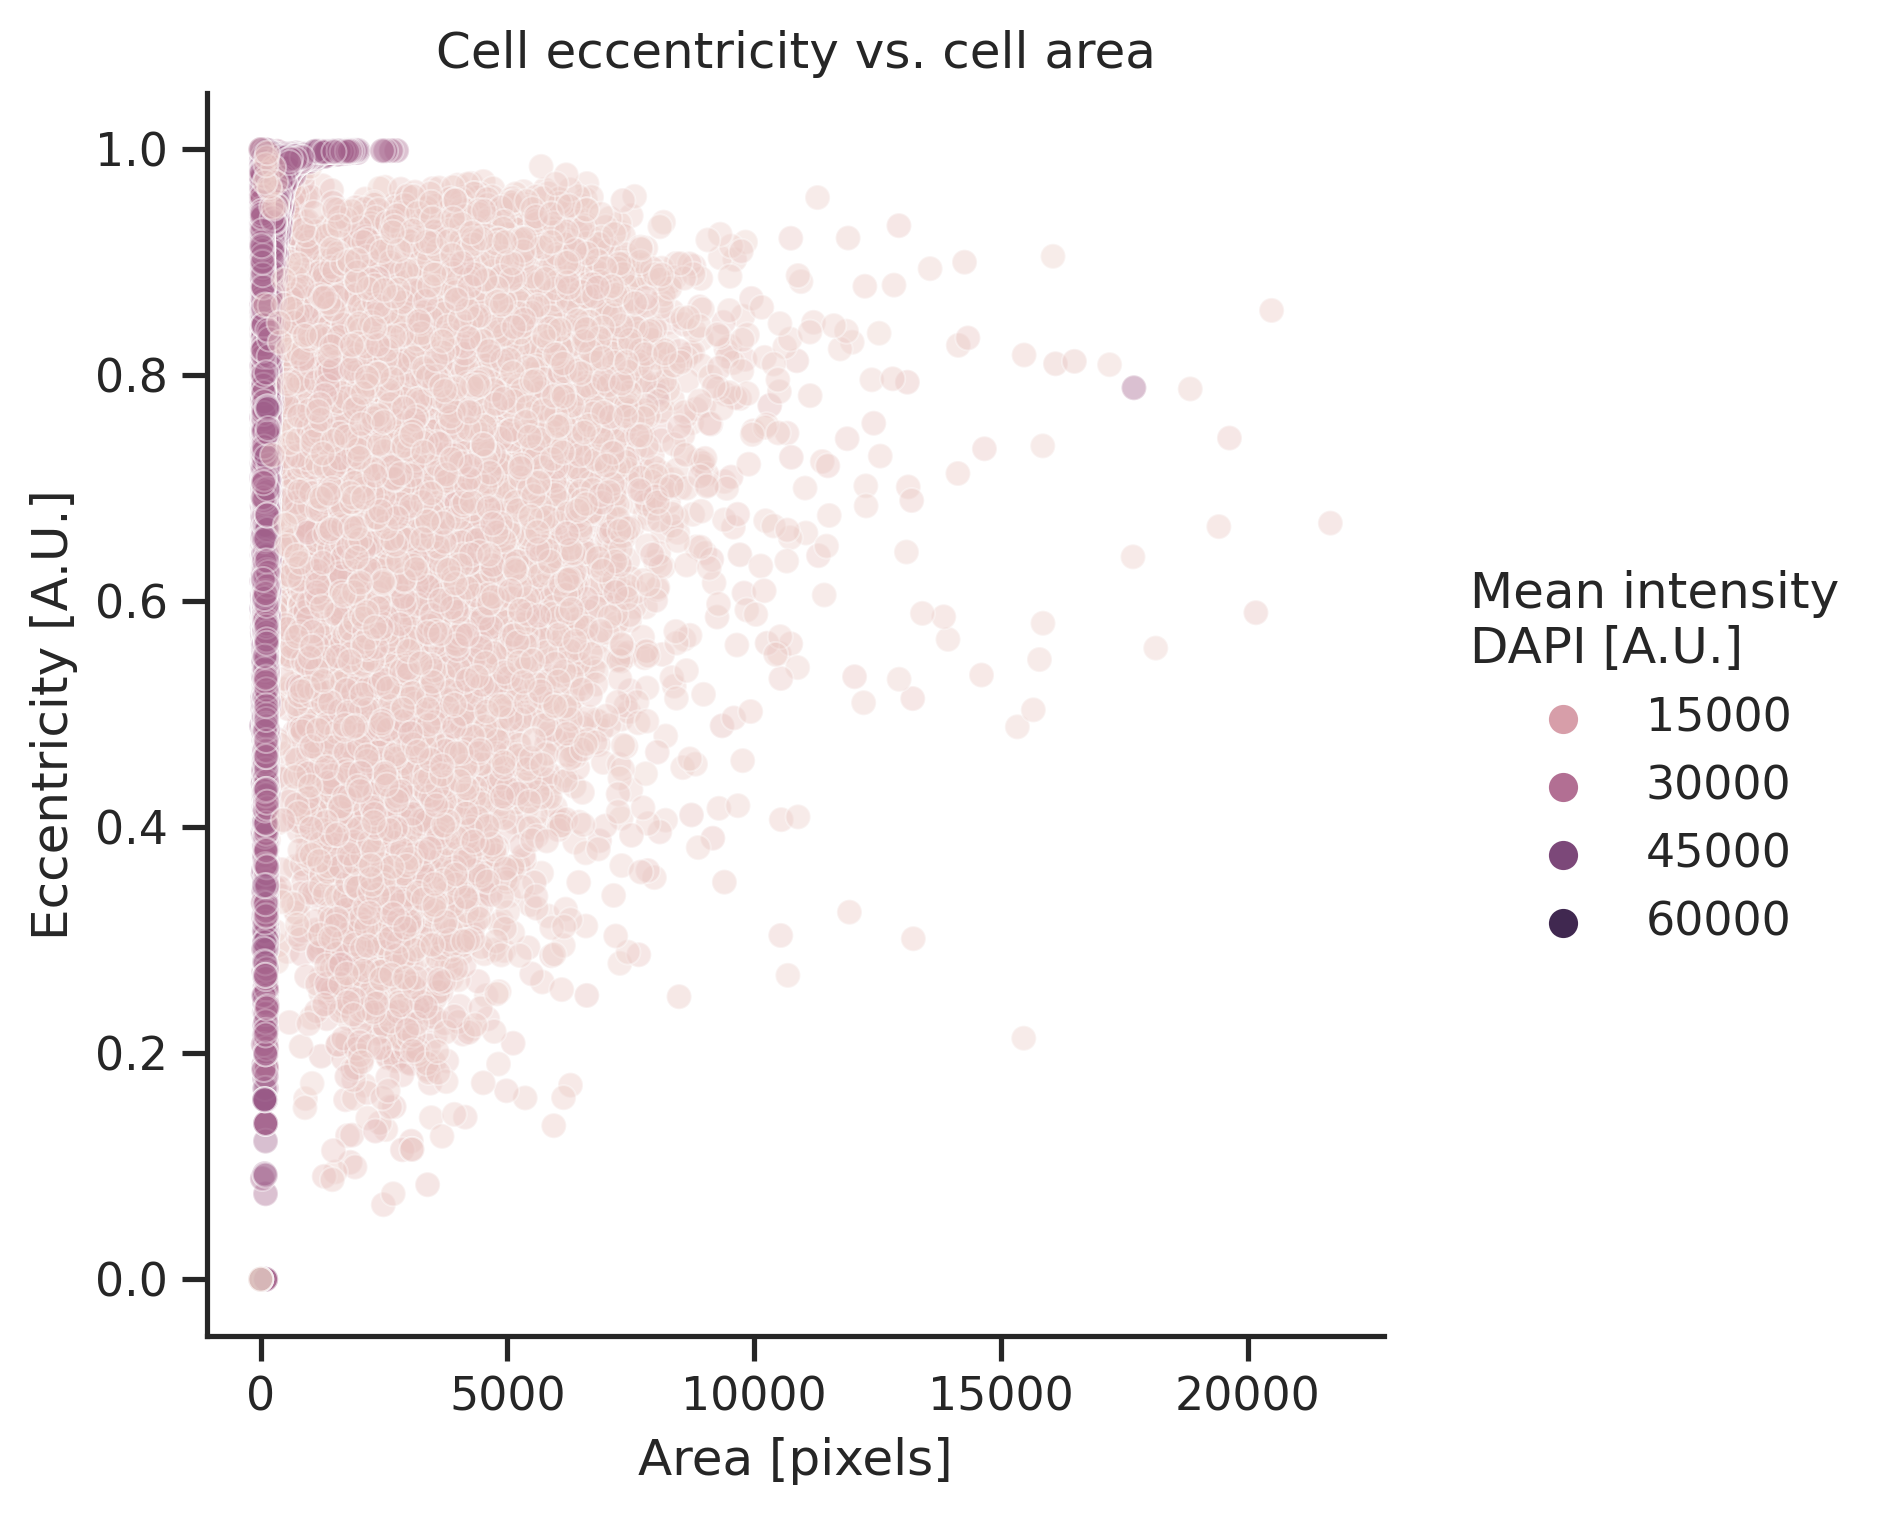

In [ ]:
p3 = sns.relplot(data=dd, x="area", y="eccentricity", hue="mean_intensity-0", alpha=0.4)
p3.set(title="Cell eccentricity vs. cell area",
      xlabel="Area [pixels]", 
      ylabel="Eccentricity [A.U.]")
p3._legend.set_title("Mean intensity\nDAPI [A.U.]")

What have we done here? We plotted eccentricity vs area and used the mean DAPI intensity as a hue. Eccentricity is the ratio of the distance between two focal points over the length of the major axis. If eccentricity = 1 it is a perfect circle.

We can see three things:
 

1.   A large population of cells with a similarly low mean DAPI intensity (< 15'000) that is spread in both eccentricity and area.
2.   A second population of very small cells (area ~0) with high intensity (> 30'000).
3.   A third population of almost perfectly round cells (eccentricity == 1) with high intensity.

Recall what we said about mitotic cells and debris. Our second population probably represents mitotic cells, while the third corresponds to debris.

In our next step we will thus filter cells for eccentricity and area. Not only will we filter for small cells, we will also filter for very large cells (where several cells were combined into one, see histogram above).



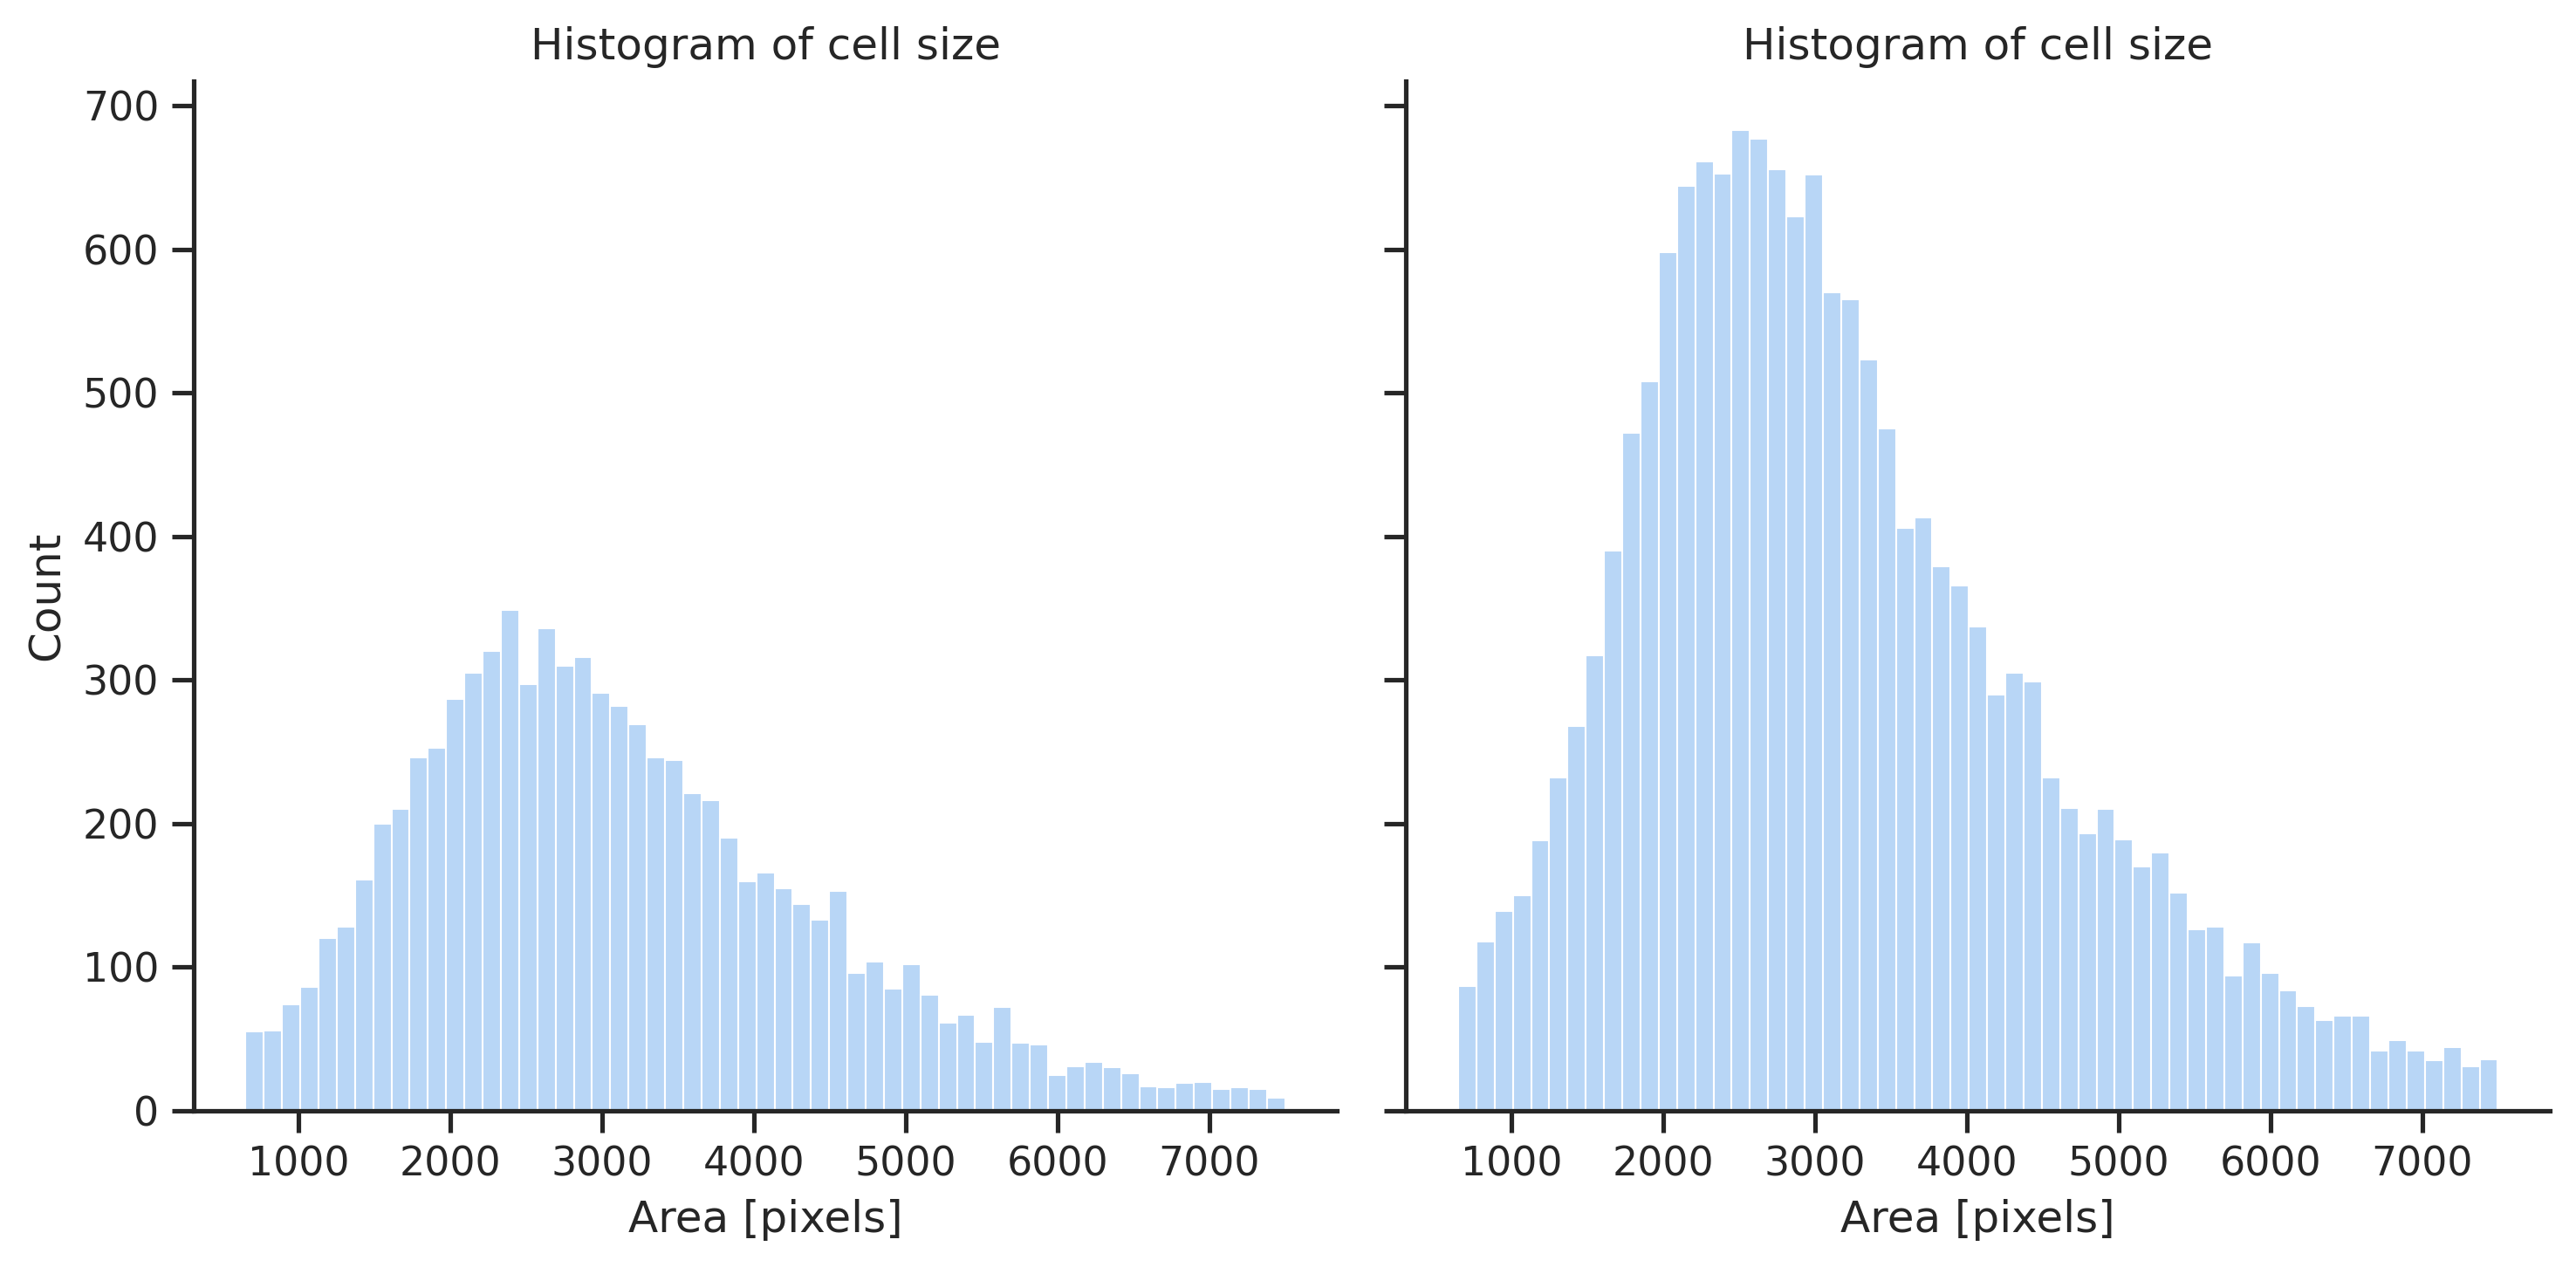

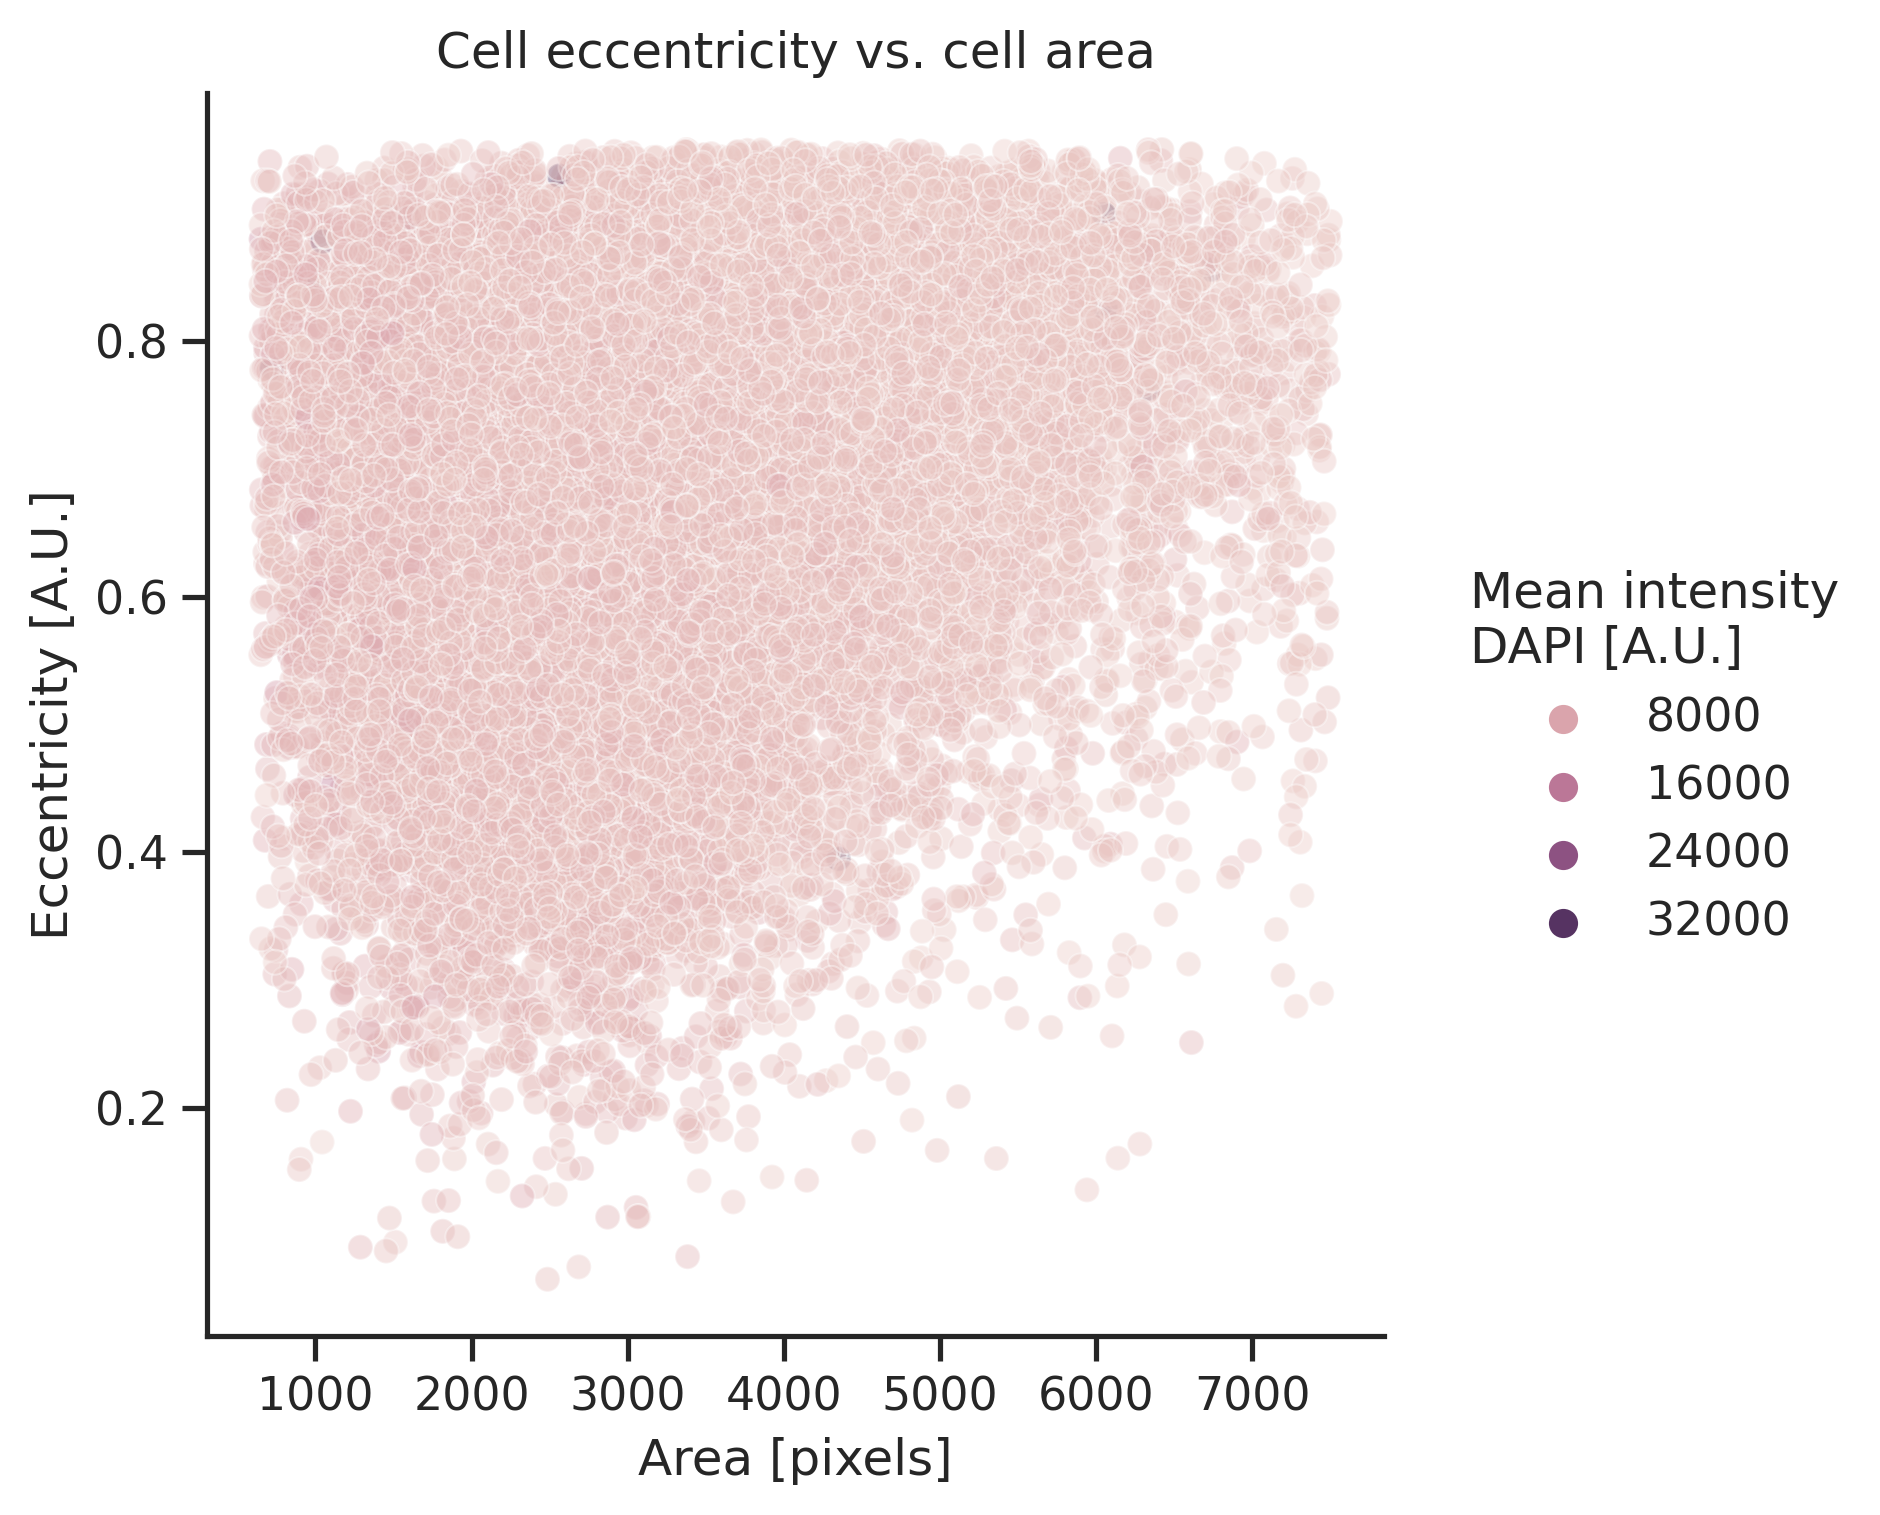

In [ ]:
dd_filtered = dd[(dd["area"]>=650) & (dd["area"]<=7500) & (dd["eccentricity"]<=0.95)]

p4 = sns.displot(data=dd_filtered, x="area", col="well",
                 facet_kws=dict(margin_titles=True))
p4.set(title="Histogram of cell size",
      xlabel="Area [pixels]")

p5 = sns.relplot(data=dd_filtered, x="area", y="eccentricity", 
                 hue="mean_intensity-0", alpha=0.4)
p5.set(title="Cell eccentricity vs. cell area",
      xlabel="Area [pixels]", 
      ylabel="Eccentricity [A.U.]")
p5._legend.set_title("Mean intensity\nDAPI [A.U.]")

So, with those quality checks settled, let's dig deeper. First we might ask, well how many cells do we have where transfection actually worked? Remember that GFP was our positive control: if cells express GFP we know that transfection worked. So now we can create a new variable called `transfection`. This will be a binary (0 = no, 1 = yes) for each cell depending on whether it reached a GFP threshold or not (i.e. was transfected or not).

In [ ]:
wells = set(dd_filtered["well"])

dd_filtered["transfected"] = np.where(dd_filtered["max_intensity-1"]>500, 1, 0)

pd.options.mode.chained_assignment = None

print("Transfection efficiency of GFP plasmid:\n")

for well in wells:
  t = dd_filtered[(dd_filtered["well"]==well)].shape[0] #No. Total
  p = dd_filtered[(dd_filtered["transfected"]==1) & (dd_filtered["well"]==well)].shape[0] #No. of transfected
  n = dd_filtered[(dd_filtered["transfected"]==0) & (dd_filtered["well"]==well)].shape[0] #No. of non-transfected
  print("Well %s" % (well))
  print("Total cells: %d\nTransfected: %d\nNon-transfected: %d" % (t,p,n))
  print("\nTransfection Efficiency: ", p/t*100, "%\n")

Transfection efficiency of GFP plasmid:

Well D05
Total cells: 8061
Transfected: 3777
Non-transfected: 4284

Transfection Efficiency:  46.85522887979159 %

Well E05
Total cells: 16373
Transfected: 5206
Non-transfected: 11167

Transfection Efficiency:  31.796249923654795 %



As you can see, the transfection efficiency is pretty low. Using our method, we'd expect aroun 80% or higher. However, this value is somewhat expected, as the GFP plasmid does not work well for some reason. 

So now, after all of this, let's compare the expression of CD48 WT and Mut for the GFP positive cells. We're going to use a log-transformed y-scale so that we can actually see (the range of mean intensity is quite large).

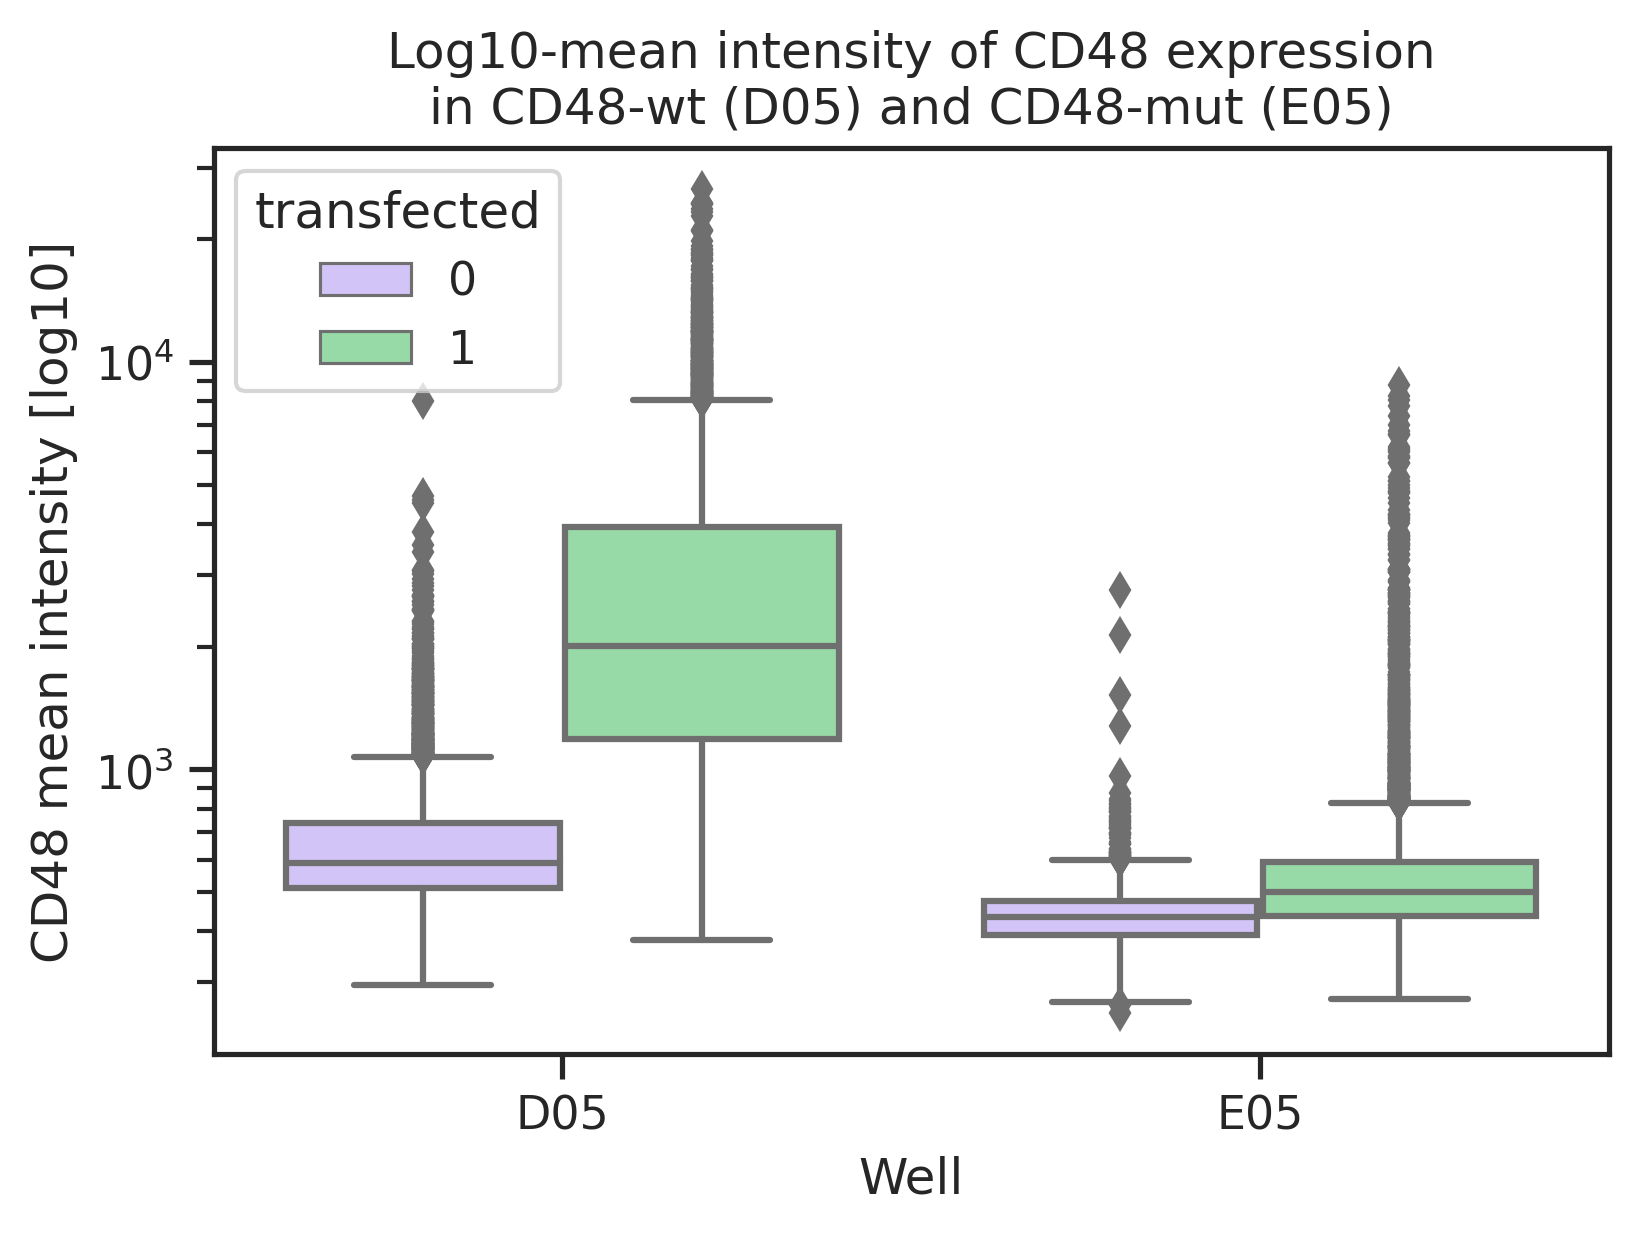

In [ ]:
p6 = sns.boxplot(data=dd_filtered, x="well", y="mean_intensity-2",
            hue="transfected", palette=["m", "g"])
p6.set(title="Log2-mean intensity of CD48 expression\nin CD48-wt (D05) and CD48-mut (E05)",
      xlabel="Well", 
      ylabel="CD48 mean intensity [log2]")
p6.set_yscale("log", basey=2) #Log transform

## End
Naturally, there's much more that we can do here. But this simple analysis should suffice for this course. We will also forget about doing a comparison of statistical significance for the difference in expression between those groups. Of course, you're free to do that if you want to.